<a href="https://colab.research.google.com/github/tomiambro/covid_transfer_learning/blob/main/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
!pip install --upgrade git+https://github.com/fastai/fastai.git &> 2
!pip install pip install nbdev &> 2

# Covid detection using CT Scans

In [2]:
from fastai.vision.all import *
from torchvision import transforms as T

import gc

In [3]:
dataset_path = 'gdrive/MyDrive/machine_learning/datasets/covid_dataset'  #change dir to your project folder
folder_path = 'gdrive/MyDrive/machine_learning/covid/'

In [6]:
from google.colab import drive

drive._mount('/content/gdrive')

Mounted at /content/gdrive


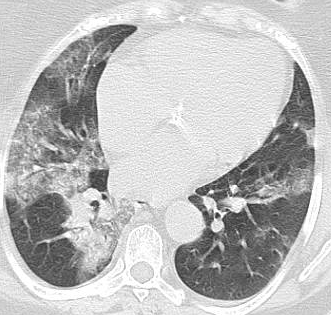

In [7]:
im = Image.open(f"{dataset_path}/COVID/Covid (1000).png")
im.to_thumb(350,350)

Create array with Path objects to imgs

In [8]:
path = Path(f"{dataset_path}")

In [9]:
imgs = get_image_files(f"{dataset_path}")
imgs[:5]

(#5) [Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1227).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1229).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1226).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1209).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1238).png')]

In [10]:
covid = DataBlock(
    blocks=(ImageBlock, CategoryBlock(['non-COVID', 'COVID'], sort=False)), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(350,350))

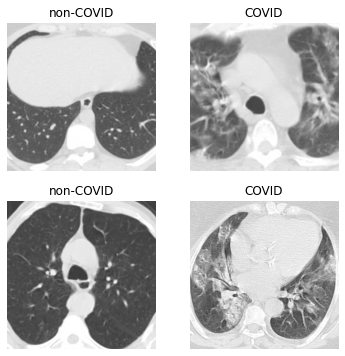

In [11]:
dls = covid.dataloaders(path)
dls.valid.show_batch(max_n=4)

In [12]:
res34 = cnn_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [13]:
lr = 1e-3
res34.fine_tune(4, lr, freeze_epochs=2)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.936382,0.480233,0.782796,0.748971,02:27
1,0.656329,0.318184,0.869070,0.942387,00:43


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.315611,0.180930,0.930233,0.905350,00:58
1,0.210804,0.144869,0.955603,0.930041,00:56
2,0.129479,0.116322,0.957576,0.975309,00:56
3,0.088223,0.103004,0.965092,0.967078,00:56


In [14]:
df_rec34 = pd.DataFrame(res34.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [15]:
df_rec34

,train_loss,valid_loss,f1_score,recall_score
0,0.315611,0.180930,0.930233,0.905350
1,0.210804,0.144869,0.955603,0.930041
2,0.129479,0.116322,0.957576,0.975309
3,0.088223,0.103004,0.965092,0.967078


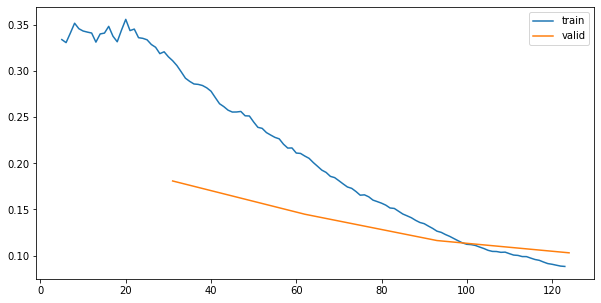

In [16]:
plt.figure(figsize=(10,5))
res34.recorder.plot_loss()

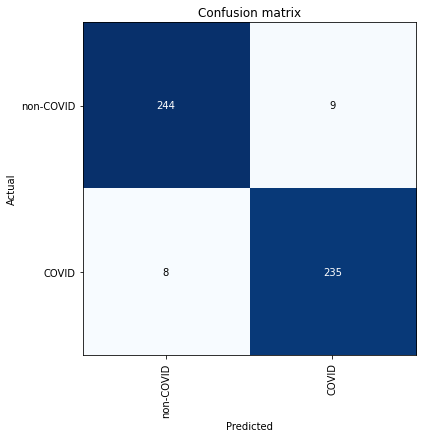

In [17]:
interp = ClassificationInterpretation.from_learner(res34)
interp.plot_confusion_matrix(figsize=(6,6))

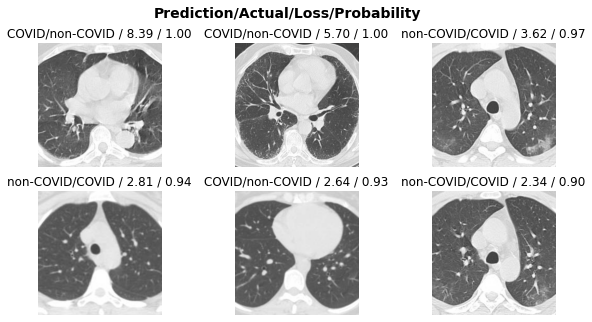

In [18]:
interp.plot_top_losses(6, figsize=(10,5))

In [19]:
res34.predict(f"{dataset_path}/COVID/Covid (1000).png")

('COVID', TensorBase(1), TensorBase([2.2458e-05, 9.9998e-01]))

In [20]:
res34.export('res34.pkl')

In [21]:
covid = covid.new(
    item_tfms=Resize(350,350),
    batch_tfms=[DeterministicFlip, Contrast(p=1, draw=1.50)])
dls = covid.dataloaders(path)

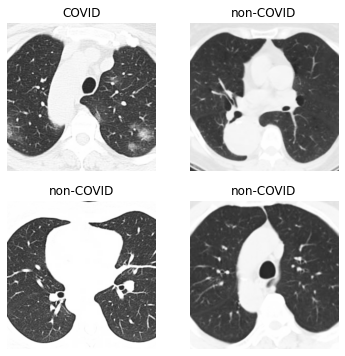

In [22]:
dls.train.show_batch(max_n=4)

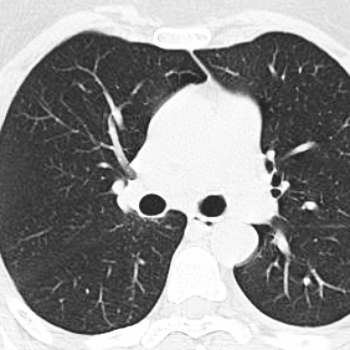

In [23]:
train_features, train_labels = next(iter(dls.train))
trans = T.ToPILImage()
trans(train_features[0])

In [24]:
res34_con = cnn_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

In [25]:
lr = 1e-3
res34_con.fine_tune(5, lr, freeze_epochs=1)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.772730,0.529037,0.780303,0.847737,00:46


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.449786,0.428904,0.837887,0.946502,00:59
1,0.292585,0.215965,0.908722,0.921811,00:59
2,0.193773,0.174087,0.917355,0.913580,00:59
3,0.129626,0.186658,0.934653,0.971193,00:59
4,0.092103,0.173676,0.933868,0.958848,00:59


In [26]:
df_rec34_con = pd.DataFrame(res34_con.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [27]:
df_rec34_con

,train_loss,valid_loss,f1_score,recall_score
0,0.449786,0.428904,0.837887,0.946502
1,0.292585,0.215965,0.908722,0.921811
2,0.193773,0.174087,0.917355,0.913580
3,0.129626,0.186658,0.934653,0.971193
4,0.092103,0.173676,0.933868,0.958848


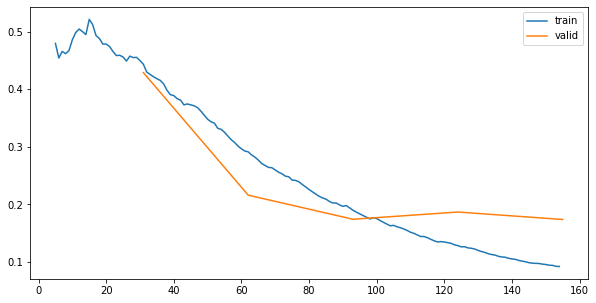

In [28]:
plt.figure(figsize=(10,5))
res34_con.recorder.plot_loss()

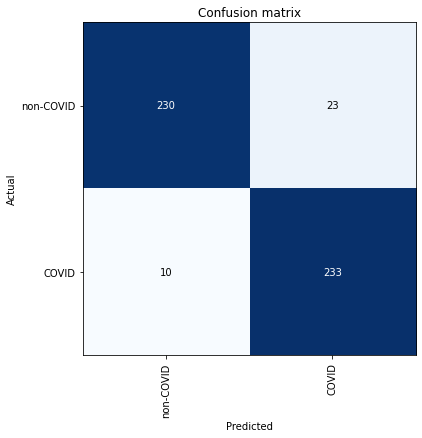

In [29]:
interp = ClassificationInterpretation.from_learner(res34_con)
interp.plot_confusion_matrix(figsize=(6,6))

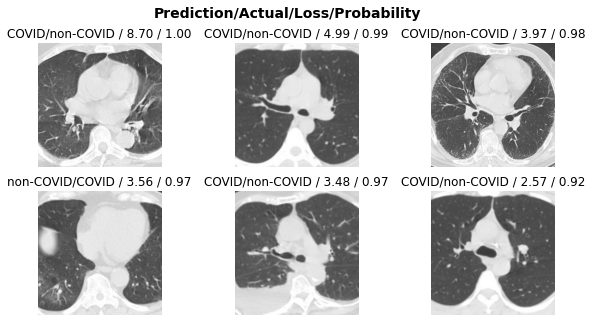

In [30]:
interp.plot_top_losses(6, figsize=(10,5))

In [31]:
res34_con.export('res34_con.pkl')

In [32]:
covid = covid.new(
    item_tfms=Resize(350,350),
    batch_tfms=[DeterministicFlip, RandomErasing(1, min_aspect=0.3, sh=0.1)])
dls = covid.dataloaders(path)

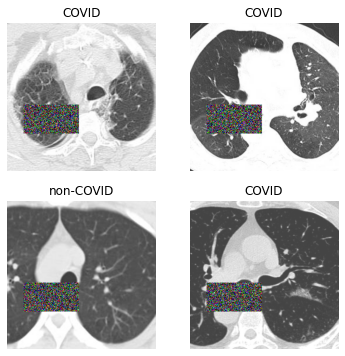

In [33]:
dls.train.show_batch(max_n=4)

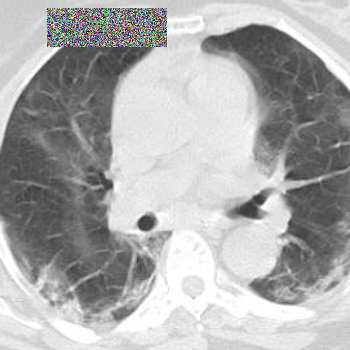

In [34]:
train_features, train_labels = next(iter(dls.train))
trans = T.ToPILImage()
trans(train_features[0])

In [35]:
res34_noise = cnn_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

In [36]:
lr = 1e-3
res34_noise.fine_tune(6, lr, freeze_epochs=2)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.976887,0.463044,0.820961,0.773663,00:46
1,0.703948,0.353838,0.873706,0.868313,00:46


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.417067,0.246736,0.903361,0.884774,00:59
1,0.360218,0.154791,0.942857,0.950617,00:59
2,0.267814,0.172553,0.934783,0.884774,00:59
3,0.206584,0.129482,0.946467,0.909465,00:59
4,0.163552,0.093187,0.968553,0.950617,00:59
5,0.138842,0.093776,0.968815,0.958848,00:59


In [37]:
df_rec34_noise = pd.DataFrame(res34_noise.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [38]:
df_rec34_noise

,train_loss,valid_loss,f1_score,recall_score
0,0.417067,0.246736,0.903361,0.884774
1,0.360218,0.154791,0.942857,0.950617
2,0.267814,0.172553,0.934783,0.884774
3,0.206584,0.129482,0.946467,0.909465
4,0.163552,0.093187,0.968553,0.950617
5,0.138842,0.093776,0.968815,0.958848


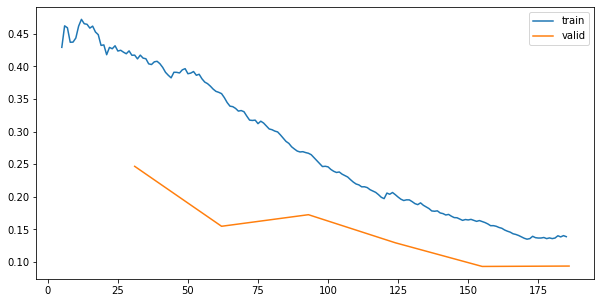

In [39]:
plt.figure(figsize=(10,5))
res34_noise.recorder.plot_loss()

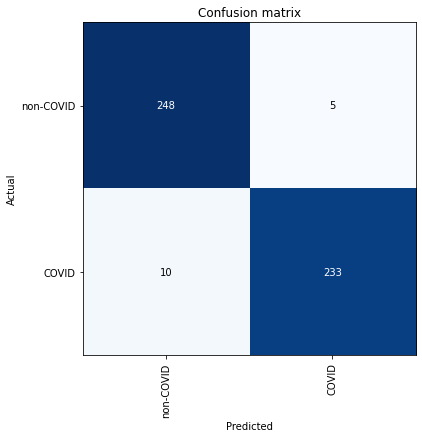

In [40]:
interp = ClassificationInterpretation.from_learner(res34_noise)
interp.plot_confusion_matrix(figsize=(6,6))

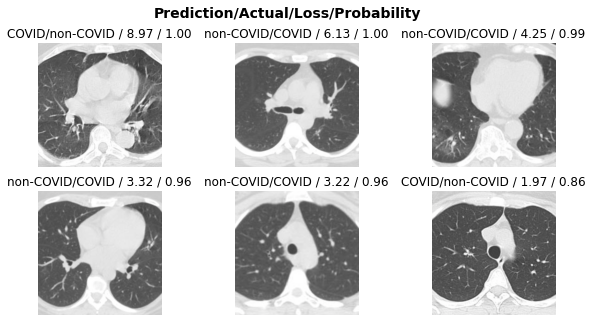

In [41]:
interp.plot_top_losses(6, figsize=(10,5))

In [42]:
res34_noise.export('res34_noise.pkl')

## Inference and Ensembling

In [51]:
class Ensemble:
  def __init__(self, dl, models : dict, vocab : list = [0, 1]):
    self.models = models
    self.vocab = vocab
    self.dl = dl
    print(f'vocab: {self.vocab}')
    for name, model in models.items():
      print(f'loaded: {name}')


  def calc_probas(self, item):
    probas = []
    for _, model in self.models.items():
      _, _, p = model.predict(item)
      probas.append(p)
    
    probas = torch.stack(probas, dim=0)
    return probas

  def predict(self, item):
    probas = self.calc_probas(item)
    mean, std = probas.mean(axis=0), probas.std(axis=0)

    return self.vocab[mean.argmax()], mean, std
  
  def get_preds(self, dl=None, with_input=True, with_loss=True, with_decoded=True, act=None):
    if dl is None: dl = self.model_list[0].dls[1]
    predictions = []
    losses = []
    for name, model in self.models.items():
      print(f'Getting predictions from {name}')
      inputs, preds, targs, decoded, loss = model.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)
      predictions.append(preds)
      losses.append(loss)
    
    print()
    preds = torch.stack(predictions).mean(0)
    decoded = preds.argmax(1)
    return inputs, preds, targs, decoded, torch.stack(losses, dim=1).mean(1)

  def calc_metrics(self, metrics : dict):
    res = {}
    _,_, targs, decoded,_ = self.get_preds(self.dl)
    for name, metric in metrics.items():
      res[name] = metric(decoded, targs)
    return res

In [52]:
en = Ensemble(dls.valid, {'res34': res34, 'res34_con': res34_con, 'res34_noise': res34_noise}, vocab=dls.valid.vocab)
pred, mean, std = en.predict(f"{dataset_path}/COVID/Covid (1000).png")

vocab: ['non-COVID', 'COVID']
loaded: res34
loaded: res34_con
loaded: res34_noise


Prediction, probabilities and standard deviation for *item*.

In [53]:
en.predict(f"{dataset_path}/non-COVID/Non-Covid (200).png")

('COVID', TensorBase([0.4143, 0.5857]), TensorBase([0.5102, 0.5102]))

Accessing a single model from within the Ensemble

In [54]:
en.models['res34_con'].predict(f"{dataset_path}/non-COVID/Non-Covid (200).png")

('COVID', TensorBase(1), TensorBase([0.0068, 0.9932]))

Calculate predictions for a whole dl

In [55]:
inputs, predictions, targs, decoded, losses = en.get_preds(dl=dls.valid, with_input=True, with_loss=True, with_decoded=True, act=None)

Getting predictions from res34


Getting predictions from res34_con


Getting predictions from res34_noise


Calculate metrics.

In [56]:
en.calc_metrics({'F1Score': F1Score(), 'Recall': Recall()})

Getting predictions from res34


Getting predictions from res34_con


Getting predictions from res34_noise


{'F1Score': 0.9713114754098362, 'Recall': 0.9753086419753086}

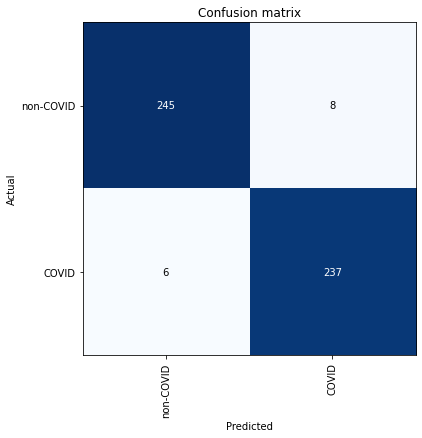

In [57]:
# interp = ClassificationInterpretation.from_learner(en, dl=dls.valid) -> calls get_preds
interp = ClassificationInterpretation(dls.valid, inputs, predictions, targs, decoded, losses)
interp.plot_confusion_matrix(figsize=(6,6))

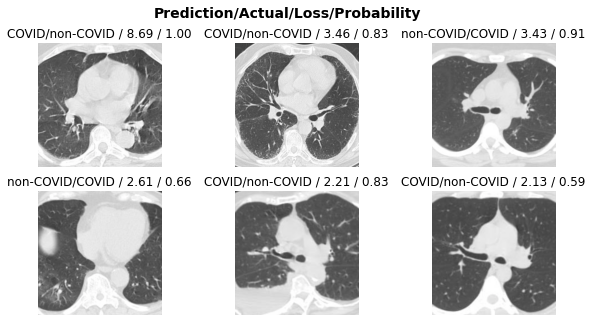

In [58]:
interp.plot_top_losses(6, figsize=(10,5))